In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.preprocessing as preprocess
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

In [2]:
images_directory = "./images/"
html_directory = "./html"
all_file_images = []
all_html_pages=[]

# One dataset images/Html with te same order
### Convert all images in feature with resnet for space reason

In [3]:
dataset=[]
resnet = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299,3))

In [4]:
for image in os.listdir(path=images_directory):
    element ={"id":int(image.split('.')[0])}
    # Read all images and convert each in float maxtrix
    _image = preprocess.image.load_img(path=images_directory+image, target_size=(299, 299))
    _image = preprocess.image.img_to_array(_image, dtype=float)
    _image = preprocess_input(_image)
    _image = np.expand_dims(_image,axis=0)
    feature = resnet.predict(_image)
    element["image"] = feature
    with open(f"{html_directory}/basic-{image.split('.')[0]}/index.html","r") as f:
        _html = f.read()
        element["html"]=f"START {_html} END"
    dataset.append(element)


In [ ]:
import pickle 
#save dataset
pickle.dump(dataset, open('dataset_jpg_html.pkl','wb'))

In [ ]:
import  pickle
#load  dataset
dataset = pickle.load(open('dataset_jpg_html.pkl','rb'))

# Generate tokens from all HTML pages

In [5]:
word_from_id = lambda x: tokenizer.index_word[x] if x in tokenizer.index_word else None

In [6]:
max_len_html_line = 100
tokenizer = keras.preprocessing.text.Tokenizer(filters='', split=" ", lower=False)
tokenizer.fit_on_texts([html['html'] for html in dataset])
for element in dataset:
    # convert all text to token & remove one dimension array asked by the tokenizer
    element["html"] = np.squeeze(tokenizer.texts_to_sequences([element["html"]]),axis=0)

In [7]:
max_html_size = max([len(s["html"]) for s in dataset] )

# Generate the Seq-to-seq of each html token page with the specific image

In [21]:
images = list()
X = list()
y = list()

In [22]:
for element in dataset:
    for i in range(1,len(element["html"])):
        input_sequence, output_sequence = element["html"][:i], element["html"][i]
        input_sequence = np.squeeze(keras.preprocessing.sequence.pad_sequences(
                                    [input_sequence], maxlen=max_html_size))
        output_sequence = np.squeeze(keras.utils.to_categorical(
                            [output_sequence], len(tokenizer.word_index) + 1))
        X.append(input_sequence[-100:])
        y.append(output_sequence)
        images.append(element['image'].squeeze())

In [23]:
len(X)

41730

In [24]:
images = np.array(images)
X = np.array(X)
y = np.array(y)

In [25]:
X.shape

(41730, 100)

# Define Keras Deep Learning Model

In [12]:
image_features = keras.layers.Input(shape=(8, 8, 1536,))
image_flat = keras.layers.Flatten()(image_features)
image_flat = keras.layers.Dense(128, activation='relu')(image_flat)
ir2_out = keras.layers.RepeatVector(max_len_html_line)(image_flat)

language_input = keras.layers.Input(shape=(max_len_html_line,))
language_model = keras.layers.Embedding(len(tokenizer.word_index) + 1, 200, input_length=max_len_html_line)(language_input)
language_model = keras.layers.LSTM(512, return_sequences=True)(language_model)
language_model = keras.layers.LSTM(512, return_sequences=True)(language_model)
language_model = keras.layers.LSTM(512, return_sequences=True)(language_model)
language_model = keras.layers.TimeDistributed(keras.layers.Dense(128, activation='relu'))(language_model)

# Create the decoder
decoder = keras.layers.concatenate([ir2_out, language_model])
decoder = keras.layers.LSTM(512, return_sequences=False)(decoder)
decoder_output = keras.layers.Dense(len(tokenizer.word_index) + 1, activation='softmax')(decoder)

# Compile the model
model = keras.models.Model(inputs=[image_features, language_input], outputs=decoder_output)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     215600      input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 8, 8, 1536)] 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 100, 512)     1460224     embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
# must be installed to generate the graph of the next code line
!pip install pydot graphviz

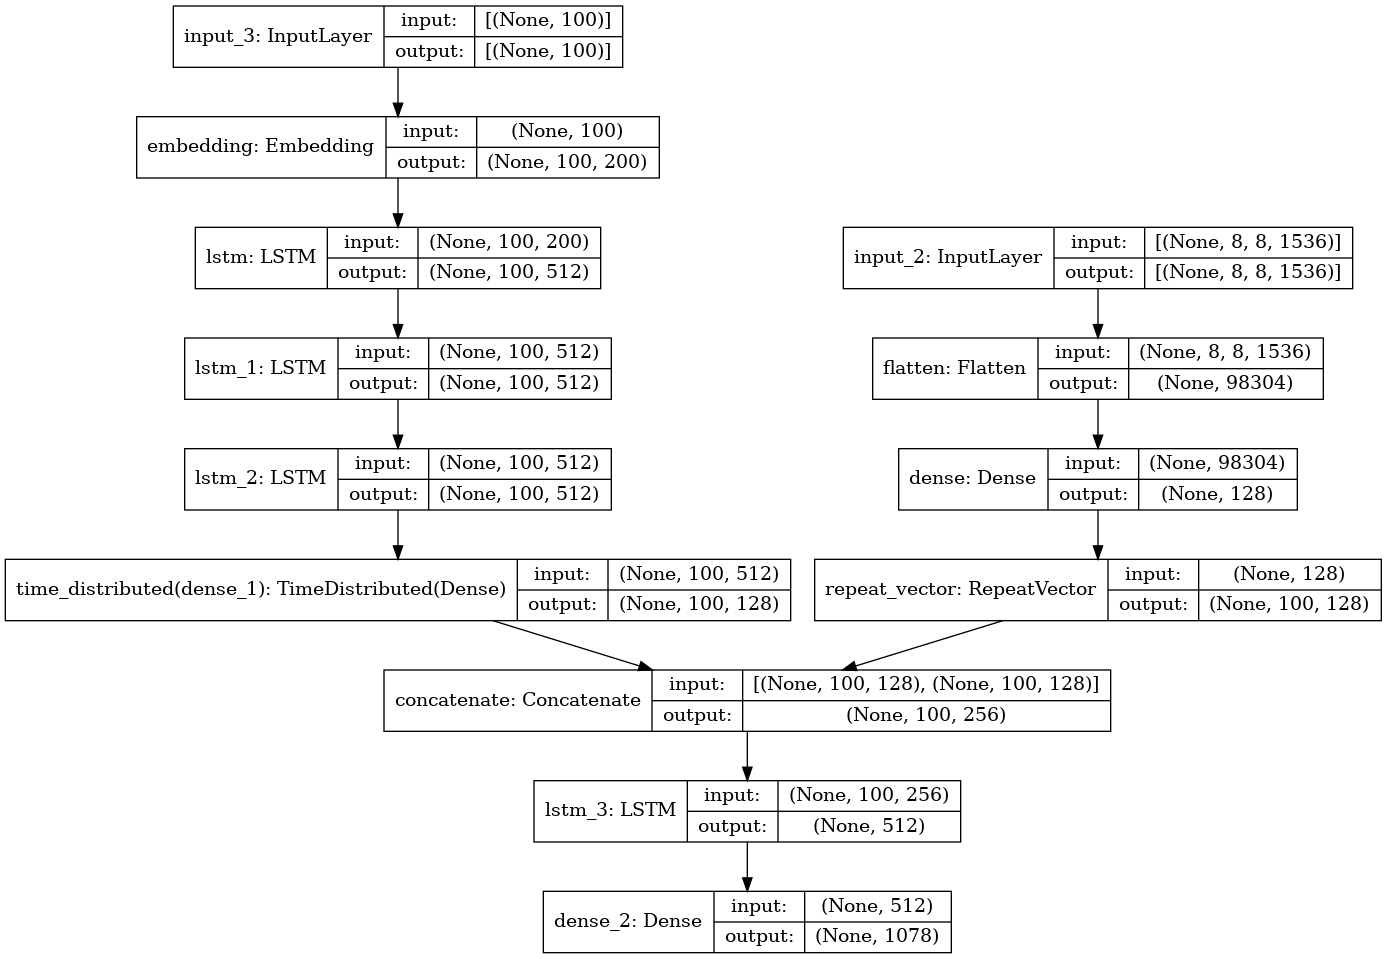

In [14]:
keras.utils.plot_model(model,show_shapes=True, show_layer_names=True)

In [ ]:
keras.backend.clear_session()

# Training the network

In [27]:
model.fit([images, X], y, batch_size=64, shuffle=False, epochs=64)

Epoch 1/64
653/653 [==============================] - 72s 110ms/step - loss: 5.4811
Epoch 2/64
653/653 [==============================] - 71s 108ms/step - loss: 5.4772
Epoch 3/64
653/653 [==============================] - 70s 107ms/step - loss: 5.4031
Epoch 4/64
653/653 [==============================] - 70s 107ms/step - loss: 5.2483
Epoch 5/64
653/653 [==============================] - 70s 106ms/step - loss: 5.1629
Epoch 6/64
653/653 [==============================] - 70s 106ms/step - loss: 5.0870
Epoch 7/64
653/653 [==============================] - 69s 106ms/step - loss: 5.0975
Epoch 8/64
653/653 [==============================] - 69s 106ms/step - loss: 5.0898
Epoch 9/64
653/653 [==============================] - 69s 106ms/step - loss: 5.0930
Epoch 10/64
653/653 [==============================] - 69s 106ms/step - loss: 5.0113
Epoch 11/64
653/653 [==============================] - 69s 106ms/step - loss: 4.8802
Epoch 12/64
653/653 [==============================] - 69s 106ms/step - lo

In [28]:
model.save('.')

INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


In [ ]:
model = keras.models.load_model('/media/datasLinux/alegrand/notebooks/my_folder/transformers')

# Prediction & generation of html source code page

In [37]:
input_text = 'START'
stop_generation = False

In [30]:
image = preprocess.image.load_img(path=images_directory+"4.jpg", target_size=(299, 299))
image = preprocess.image.img_to_array(image, dtype=float)
image = preprocess_input(image)
image = np.expand_dims(image,axis=0)
feature = resnet.predict(image)

In [38]:
while stop_generation == False:
    sequence = tokenizer.texts_to_sequences([input_text])[0][-100:]
    sequence = keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_len_html_line)
    yhat = model.predict([feature,sequence], verbose=0)
    yhat = np.argmax(yhat)
    word = word_from_id(yhat)
    if word is None or word == 'END':
        stop_generation = True
    input_text += ' '+word
    print(f" {word}", end='')

 <!DOCTYPE html>
<html lang="en" dir="ltr">
<head>
<title>Basic <h2>Column 9]><script src="scripts/html5shiv.js"></script><![endif]-->
</head>
<body>
<div class="wrapper row1">
 <header id="header" class="clear">
 <h1>Basic <h2>Column </header>
</div>
<!-- ####################################################################################################### -->
<div class="wrapper row2">
 <div id="container" class="clear">
 <div id="col1">
 <h1>&lt;h1&gt; to &lt;h6&gt; - Headline Colour and Size Are All The Same</h1>
 <p class="center">This text is aligned centre. Lorem ipsum dolor sit amet, consectetur adipiscing elit. <div </div>
 <div id="col2">
 <h2>Column <li>Nibh libero. Pellentesque aligned dolor <p ipsum lectus adipiscing elit. Integer nec odio. Praesent libero. <a href="#">Sed cursus ante dapibus</a> diam. Sed nisi. Nulla quis sem at nibh elementum imperdiet. Duis sagittis ipsum. Praesent mauris. Fusce nec tellus sed augue semper porta. Mauris massa. Vestibulum lacinia arcu e